In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sys
from time import time
import os

%pylab inline
pylab.rcParams['figure.figsize'] = (20.0, 10.0)

%load_ext autoreload
%autoreload 2

sys.path.append('..')

import isolation
import sample_players
import run_match
import my_baseline_player as custom
import book as b

from multiprocessing.pool import ThreadPool as Pool

Populating the interactive namespace from numpy and matplotlib


/Users/antelinvestigacionydesarrollo/anaconda3/envs/aind/lib/python3.5/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['time']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [2]:
# Constant parameteres
time_limit = 150
depth = 4
full_search_depth = 2
matches_per_opening = 3

# Create the agents that will play
agent_names = ('CustomPlayer1', 'CustomPlayer2')
agent1 = isolation.Agent(custom.CustomPlayer, agent_names[0])
agent2 = isolation.Agent(custom.CustomPlayer, agent_names[1])
agents = (agent1, agent2)

# Get the initial states
root = isolation.isolation.Isolation()
opening_states = list(b.get_full_states(root, depth=full_search_depth))

# Generate the matches
matches = [(agents, state, time_limit, match_id) 
           for match_id, state in enumerate(opening_states)]
matches = matches * 3
print('Generated {} matches.'.format(len(matches)))

Generated 29403 matches.


In [ ]:
num_processes = 4
batch_size = 100
batch_num_file = 'batch_num.txt'

# Small test for debugging
# matches = matches[:100]

# Create or load the book
book = b.load_latest_book(depth=depth)

# Make some batches to save the results once in a while
x = matches
batches = [x[i*batch_size:(i+1)*batch_size] 
           for i in range(len(x) // batch_size + (len(x) % batch_size != 0))]

# Get only the unprocessed batches
if os.path.exists(batch_num_file):
    with open(batch_num_file, 'r') as file:
        last_batch = int(file.read())
else:
    last_batch = -1

# Now fill the book!
pool = Pool(num_processes)

for batch_num in range(last_batch + 1, len(batches)):
    tic = time.time()
    batch = batches[batch_num]
    print('Processing batch {} of {}'.format(batch_num, len(batches)))
    for result in pool.imap_unordered(isolation.play, batch):
        winner, game_history, match_id = result
        # print('Results for match {}: {} wins.'.format(match_id, winner.name))
        _, state, _, _ = matches[match_id]
        if state.locs[1] is not None:
            game_history.insert(0,state.locs[1])
        if state.locs[0] is not None:
            game_history.insert(0,state.locs[0])
        root = isolation.isolation.Isolation()
        b.process_game_history(root,
                               game_history, 
                               book,
                               agent_names.index(winner.name),
                               active_player=state.ply_count % 2,
                               depth=depth)
    toc = time.time()
    print('Batch time {} seconds.'.format((toc-tic)))
    b.save_book(book)
    with open(batch_num_file, 'w') as file:
        file.write(str(batch_num))
    b.remove_old_books()

Processing batch 1 of 295


In [4]:
sum(abs(value[0]) for value in book.values())

1060

In [5]:
sum(abs(value[1]) for value in book.values())

1300

In [6]:
29403*34 / (10*3600)  # Estimated time in hours

27.7695

In [7]:
import pandas as pd

v = pd.Series([v[0] for v in book.values()])

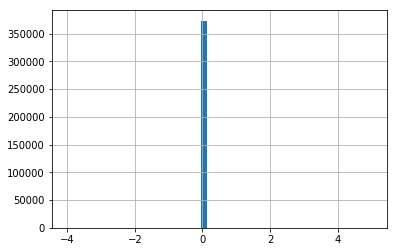

In [8]:
v.hist(bins=50)

In [9]:
v.describe()

count    374097.000000
mean          0.000080
std           0.060206
min          -4.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           5.000000
dtype: float64

In [10]:
v.min()

-4

In [11]:
worst = min(((k, v) for k, v in book.items()), key=lambda x: x[1][0])
worst[0]

(Isolation(board=41523161203939122082683632224299007, ply_count=0, locs=(None, None)),
 96)

In [12]:
from isolation.isolation import Isolation
state = Isolation(board=41523161203939122082683632224299007, ply_count=0, locs=(None, None))

print(isolation.DebugState.from_state(state.result(57)))


+ - + - + - + - + - + - + - + - + - + - + - +
|   |   |   |   |   |   |   |   |   |   |   |
+ - + - + - + - + - + - + - + - + - + - + - +
|   |   |   |   |   |   |   |   |   |   |   |
+ - + - + - + - + - + - + - + - + - + - + - +
|   |   |   |   |   |   |   |   |   |   |   |
+ - + - + - + - + - + - + - + - + - + - + - +
|   |   |   |   |   |   |   |   |   |   |   |
+ - + - + - + - + - + - + - + - + - + - + - +
|   |   |   |   |   | 1 |   |   |   |   |   |
+ - + - + - + - + - + - + - + - + - + - + - +
|   |   |   |   |   |   |   |   |   |   |   |
+ - + - + - + - + - + - + - + - + - + - + - +
|   |   |   |   |   |   |   |   |   |   |   |
+ - + - + - + - + - + - + - + - + - + - + - +
|   |   |   |   |   |   |   |   |   |   |   |
+ - + - + - + - + - + - + - + - + - + - + - +
|   |   |   |   |   |   |   |   |   |   |   |
+ - + - + - + - + - + - + - + - + - + - + - +



What about the other symmetrical ones

In [13]:
s1 = (Isolation(board=41523161203939122082683632224299007, ply_count=0, locs=(None, None)), 56)
s2 = (Isolation(board=41523161203939122082683632224299007, ply_count=0, locs=(None, None)), 58)
s3 = (Isolation(board=41523161203939122082683632224299007, ply_count=0, locs=(None, None)), 70)
s4 = (Isolation(board=41523161203939122082683632224299007, ply_count=0, locs=(None, None)), 44)

In [14]:
book[s1]

[0, 12]

In [15]:
book[s2]

[0, 12]

In [16]:
book[s3]

[4, 4]

In [17]:
book[s4]

[4, 4]

### I think I have ply_count=1,2,3,4 in the book but not ply_count=0

In [18]:
len(book.items())

374097

### Idea: show a heat matrix for the initial move

In [19]:
first = {item:value[0] for item, value in book.items() if item[0].ply_count==0}

In [20]:
len(first)

99

In [21]:
first

{(Isolation(board=41523161203939122082683632224299007, ply_count=0, locs=(None, None)),
  0): -1,
 (Isolation(board=41523161203939122082683632224299007, ply_count=0, locs=(None, None)),
  1): -3,
 (Isolation(board=41523161203939122082683632224299007, ply_count=0, locs=(None, None)),
  2): 3,
 (Isolation(board=41523161203939122082683632224299007, ply_count=0, locs=(None, None)),
  3): 0,
 (Isolation(board=41523161203939122082683632224299007, ply_count=0, locs=(None, None)),
  4): 3,
 (Isolation(board=41523161203939122082683632224299007, ply_count=0, locs=(None, None)),
  5): 0,
 (Isolation(board=41523161203939122082683632224299007, ply_count=0, locs=(None, None)),
  6): 3,
 (Isolation(board=41523161203939122082683632224299007, ply_count=0, locs=(None, None)),
  7): 0,
 (Isolation(board=41523161203939122082683632224299007, ply_count=0, locs=(None, None)),
  8): 3,
 (Isolation(board=41523161203939122082683632224299007, ply_count=0, locs=(None, None)),
  9): -3,
 (Isolation(board=415231612

In [22]:
pos_value = {key[1]:value for key,value in first.items()}
pos_value

{0: -1,
 1: -3,
 2: 3,
 3: 0,
 4: 3,
 5: 0,
 6: 3,
 7: 0,
 8: 3,
 9: -3,
 10: -1,
 13: 2,
 14: -2,
 15: -1,
 16: 3,
 17: -1,
 18: -4,
 19: -1,
 20: 3,
 21: -1,
 22: -2,
 23: 2,
 26: 0,
 27: 2,
 28: -1,
 29: 0,
 30: 1,
 31: 0,
 32: 1,
 33: 0,
 34: -1,
 35: 2,
 36: 0,
 39: 2,
 40: 0,
 41: 1,
 42: -2,
 43: 5,
 44: 4,
 45: 5,
 46: -2,
 47: 1,
 48: 0,
 49: 2,
 52: -2,
 53: 0,
 54: -2,
 55: 0,
 56: 0,
 57: 4,
 58: 0,
 59: 0,
 60: -2,
 61: 0,
 62: -2,
 65: 2,
 66: 0,
 67: 1,
 68: -2,
 69: 5,
 70: 4,
 71: 5,
 72: -2,
 73: 1,
 74: 0,
 75: 2,
 78: 0,
 79: 2,
 80: -1,
 81: 0,
 82: 1,
 83: 0,
 84: 1,
 85: 0,
 86: -1,
 87: 2,
 88: 0,
 91: 2,
 92: -2,
 93: -1,
 94: 3,
 95: -1,
 96: -4,
 97: -1,
 98: 3,
 99: -1,
 100: -2,
 101: 2,
 104: -1,
 105: -3,
 106: 3,
 107: 0,
 108: 3,
 109: 0,
 110: 3,
 111: 0,
 112: 3,
 113: -3,
 114: -1}

In [23]:
filled_vals = dict(zip(range(115),[0]*115))
filled_vals.update(pos_value)
filled_vals

{0: -1,
 1: -3,
 2: 3,
 3: 0,
 4: 3,
 5: 0,
 6: 3,
 7: 0,
 8: 3,
 9: -3,
 10: -1,
 11: 0,
 12: 0,
 13: 2,
 14: -2,
 15: -1,
 16: 3,
 17: -1,
 18: -4,
 19: -1,
 20: 3,
 21: -1,
 22: -2,
 23: 2,
 24: 0,
 25: 0,
 26: 0,
 27: 2,
 28: -1,
 29: 0,
 30: 1,
 31: 0,
 32: 1,
 33: 0,
 34: -1,
 35: 2,
 36: 0,
 37: 0,
 38: 0,
 39: 2,
 40: 0,
 41: 1,
 42: -2,
 43: 5,
 44: 4,
 45: 5,
 46: -2,
 47: 1,
 48: 0,
 49: 2,
 50: 0,
 51: 0,
 52: -2,
 53: 0,
 54: -2,
 55: 0,
 56: 0,
 57: 4,
 58: 0,
 59: 0,
 60: -2,
 61: 0,
 62: -2,
 63: 0,
 64: 0,
 65: 2,
 66: 0,
 67: 1,
 68: -2,
 69: 5,
 70: 4,
 71: 5,
 72: -2,
 73: 1,
 74: 0,
 75: 2,
 76: 0,
 77: 0,
 78: 0,
 79: 2,
 80: -1,
 81: 0,
 82: 1,
 83: 0,
 84: 1,
 85: 0,
 86: -1,
 87: 2,
 88: 0,
 89: 0,
 90: 0,
 91: 2,
 92: -2,
 93: -1,
 94: 3,
 95: -1,
 96: -4,
 97: -1,
 98: 3,
 99: -1,
 100: -2,
 101: 2,
 102: 0,
 103: 0,
 104: -1,
 105: -3,
 106: 3,
 107: 0,
 108: 3,
 109: 0,
 110: 3,
 111: 0,
 112: 3,
 113: -3,
 114: -1}

In [24]:
W = 11
x = list(filled_vals.values())
rows = [x[i*(W+2):(i+1)*(W+2)] 
           for i in range(len(x) // (W+2) + (len(x) % (W+2) != 0))]

In [25]:
rows

[[-1, -3, 3, 0, 3, 0, 3, 0, 3, -3, -1, 0, 0],
 [2, -2, -1, 3, -1, -4, -1, 3, -1, -2, 2, 0, 0],
 [0, 2, -1, 0, 1, 0, 1, 0, -1, 2, 0, 0, 0],
 [2, 0, 1, -2, 5, 4, 5, -2, 1, 0, 2, 0, 0],
 [-2, 0, -2, 0, 0, 4, 0, 0, -2, 0, -2, 0, 0],
 [2, 0, 1, -2, 5, 4, 5, -2, 1, 0, 2, 0, 0],
 [0, 2, -1, 0, 1, 0, 1, 0, -1, 2, 0, 0, 0],
 [2, -2, -1, 3, -1, -4, -1, 3, -1, -2, 2, 0, 0],
 [-1, -3, 3, 0, 3, 0, 3, 0, 3, -3, -1]]

In [26]:
for i in range(len(rows)-1):
    rows[i] =rows[i][:-2]
rows

[[-1, -3, 3, 0, 3, 0, 3, 0, 3, -3, -1],
 [2, -2, -1, 3, -1, -4, -1, 3, -1, -2, 2],
 [0, 2, -1, 0, 1, 0, 1, 0, -1, 2, 0],
 [2, 0, 1, -2, 5, 4, 5, -2, 1, 0, 2],
 [-2, 0, -2, 0, 0, 4, 0, 0, -2, 0, -2],
 [2, 0, 1, -2, 5, 4, 5, -2, 1, 0, 2],
 [0, 2, -1, 0, 1, 0, 1, 0, -1, 2, 0],
 [2, -2, -1, 3, -1, -4, -1, 3, -1, -2, 2],
 [-1, -3, 3, 0, 3, 0, 3, 0, 3, -3, -1]]

In [27]:
rows = np.array(rows)
rows

array([[-1, -3,  3,  0,  3,  0,  3,  0,  3, -3, -1],
       [ 2, -2, -1,  3, -1, -4, -1,  3, -1, -2,  2],
       [ 0,  2, -1,  0,  1,  0,  1,  0, -1,  2,  0],
       [ 2,  0,  1, -2,  5,  4,  5, -2,  1,  0,  2],
       [-2,  0, -2,  0,  0,  4,  0,  0, -2,  0, -2],
       [ 2,  0,  1, -2,  5,  4,  5, -2,  1,  0,  2],
       [ 0,  2, -1,  0,  1,  0,  1,  0, -1,  2,  0],
       [ 2, -2, -1,  3, -1, -4, -1,  3, -1, -2,  2],
       [-1, -3,  3,  0,  3,  0,  3,  0,  3, -3, -1]])

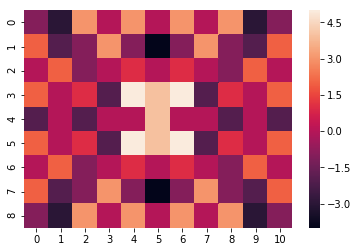

In [29]:
import seaborn as sns
sns.heatmap(rows)

In [33]:
second = {item:value[0] for item, value in book.items() if item[0].ply_count==1}

In [34]:
len(second)

9702

In [35]:
pd.Series(list(second.values())).describe()

count    9702.000000
mean       -0.004123
std         0.206041
min        -2.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         2.000000
dtype: float64

In [36]:
third = {item:value[0] for item, value in book.items() if item[0].ply_count==2}

In [37]:
len(third)

55096

In [38]:
pd.Series(list(third.values())).describe()

count    55096.000000
mean         0.000726
std          0.085204
min         -1.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
dtype: float64

In [39]:
fourth = {item:value[0] for item, value in book.items() if item[0].ply_count==3}
len(fourth)

309200

In [40]:
pd.Series(list(fourth.values())).describe()

count    309200.000000
mean         -0.000032
std           0.017984
min          -1.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
dtype: float64

In [41]:
sum(np.array(list(third.values())) != 0)

400

In [42]:
sum(np.array(list(fourth.values())) != 0)

100